In [1]:
#importing and pre-processing data
import os 
import csv
import glob
import pandas as pd
import chardet

#read in the data frame
path = r'D:\Data Science\yelp_data_v0_1.csv'
yelp_review_df = pd.read_csv(path, encoding = 'windows-1252')

In [2]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

#extract just yelp rating and the reviews from primary data set
rating = yelp_review_df['Reviewer Rating Clean']
raw_reviews = yelp_review_df['Review']

#preprocessing all reviews - include only letters, lowercase letters, remove stop words and join list in para form
def review_to_words(raw_review): 
    
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    raw_words = letters_only.lower().split()
    stops = set(stopwords.words('english')) #python searching a set is faster than a list, so we convert stopwords to a set.
    meaningful_words = [w for w in raw_words if not w in stops]
    return(' '.join(meaningful_words))

clean_reviews = []
total_num_reviews = raw_reviews.shape[0]

for i in range(0, total_num_reviews):
    clean_reviews.append(review_to_words(raw_reviews[i]))
    


In [3]:
#create df with numerical ratings and good vs. bad ratings
yelp_df = pd.concat([pd.DataFrame(clean_reviews), pd.DataFrame(rating)], axis = 1)
yelp_df.columns = ['clean_reviews','rating']

#clear memory 
raw_reviews = []


gb_rating = []
for i in yelp_df.rating:
    gb_rating.append(float(1.0) if (i == 4 or i == 5) else float(0.0))

#create dataframe with good bad ratings where 4 or 5 is good, and others are bad 
yelp_df = pd.concat([pd.DataFrame(clean_reviews), pd.DataFrame(gb_rating)], axis = 1)
yelp_df.columns = ['clean_reviews', 'gb_rating']

#drops any rows that contain invald values
yelp_df = yelp_df[pd.notnull(yelp_df.clean_reviews)]
yelp_df = yelp_df[pd.notnull(yelp_df.gb_rating)] #ratings are currently float values


In [4]:
#first test the good bad rating data set

#create the training and test set 
from sklearn.cross_validation import train_test_split

itrain , itest = train_test_split(range(yelp_df.shape[0]), train_size = 0.7)
mask = np.zeros(yelp_df.shape[0], dtype = np.bool)
mask[itrain] = 1
mask[itest] = 0
mask = (mask == 1)

# test = yelp_df[mask]
# train = yelp_df[~mask]



In [5]:
#set the vectorizer to the desired parameters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import KFold

#create functions to be called during the function calls

def make_xy(dataframe, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(dataframe.clean_reviews)
#     X = X.toarray()
    y = (dataframe.gb_rating).values.astype(np.int)
    return X, y

def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5 
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(y[test], clf.predict(X[test])) # code modification for f1 score metric
        
    return result / nfold # average

# def log_likelihood(clf, x, y):
#     prob = clf.predict_log_proba(x)
#     bad = y == 0
#     good = ~bad
#     return prob[bad, 0].sum() + prob[good, 1].sum()

In [6]:
#creating the corpus 

from sklearn.cross_validation import train_test_split, cross_val_score

my_vectorizer = CountVectorizer(analyzer = 'word', \
                            tokenizer = None, \
                            preprocessor = None, \
                            stop_words = None, \
                            min_df = 1e-4, 
                            ngram_range = (1,2))
    
Xthis, ythis = make_xy(yelp_df, my_vectorizer)

#reducing the features in the corpus with chi squared
from sklearn.feature_selection import chi2
from scipy import sparse
import itertools

chi_squared, probability  = chi2(Xthis, ythis)

index_to_keep = []
for index, value in enumerate(probability):
    if value <= .05:
        index_to_keep.append(index)
        
new_Xthis = Xthis[:,index_to_keep]

Xtrainthis = new_Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = new_Xthis[~mask]
ytestthis = ythis[~mask]

In [77]:
#train the multinomial naive-bayes classifier with the reduced corpus
from scipy.sparse import identity
from sklearn.linear_model import LogisticRegression

words = np.array(my_vectorizer.get_feature_names())
word_reduction = words[probability <= .05]

clf = LogisticRegression(C = 1)
clf.fit(Xtrainthis, ytrainthis)

x = identity(new_Xthis.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = word_reduction[ind[:20]]
bad_words = word_reduction[ind[-20:]]

likely_good_prob = probs[ind[:20]]
likely_bad_prob = probs[ind[-20:]]

print ("Good words \t    P(good review | word)\t     P(bad review | word)")
for w, l in zip(good_words, likely_good_prob):
    print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))
    
print ("Bad words\t     P(good review | word)\t     P(bad review | word)")
for w, l in zip(bad_words, likely_bad_prob):
    print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))

Good words 	    P(good review | word)	     P(bad review | word)
   definitely coming 	 	 0.92 	 	 0.08
     nice experience 	 	 0.92 	 	 0.08
          maybe even 	 	 0.91 	 	 0.09
          well worth 	 	 0.91 	 	 0.09
               peach 	 	 0.90 	 	 0.10
               beats 	 	 0.89 	 	 0.11
  never disappointed 	 	 0.89 	 	 0.11
        anything bad 	 	 0.89 	 	 0.11
      decently sized 	 	 0.89 	 	 0.11
         even better 	 	 0.89 	 	 0.11
             wait go 	 	 0.89 	 	 0.11
              superb 	 	 0.89 	 	 0.11
          least week 	 	 0.88 	 	 0.12
               plane 	 	 0.88 	 	 0.12
               stays 	 	 0.88 	 	 0.12
           bad thing 	 	 0.88 	 	 0.12
    think reasonable 	 	 0.88 	 	 0.12
           good work 	 	 0.88 	 	 0.12
        place opened 	 	 0.88 	 	 0.12
         bit spicier 	 	 0.87 	 	 0.13
Bad words	     P(good review | word)	     P(bad review | word)
        great either 	 	 0.24 	 	 0.76
        unimpressive 	 	 0.24 	 	 0.76
     fingers cr

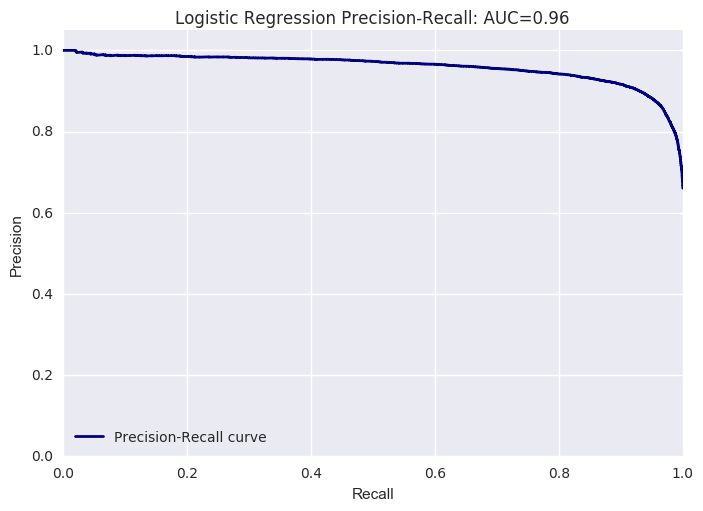

In [75]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import matplotlib.pyplot as plt 

y_predicted_score = clf.predict_proba(Xtestthis)[:,1]
precision, recall, _ = precision_recall_curve(ytestthis, y_predicted_score)
average_precision = average_precision_score(ytestthis, y_predicted_score)

plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Logistic Regression Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()


In [76]:
from sklearn.metrics import classification_report, confusion_matrix
print(new_Xthis.shape)
temp_score = clf.predict(Xtestthis)
target_names = ['bad review', 'good review']
print(classification_report(ytestthis, temp_score, target_names = target_names, digits = 4))
print (confusion_matrix(ytestthis, clf.predict(Xtestthis)))

(83349, 24915)
             precision    recall  f1-score   support

 bad review     0.8772    0.7838    0.8279      8710
good review     0.8907    0.9413    0.9153     16295

avg / total     0.8860    0.8865    0.8848     25005

[[ 6827  1883]
 [  956 15339]]


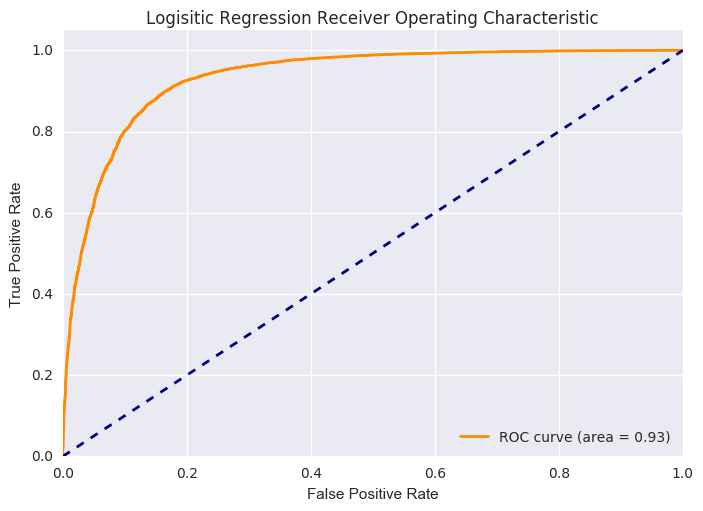

In [68]:
#plot the ROC Curve
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_score = clf.predict_proba(Xtestthis)

# print(roc_auc_score(ytestthis, y_score))
#######PLOT ROC CURVE########

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr, tpr, _ = roc_curve(ytestthis, y_score[:,1])
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logisitic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [69]:
#testing uncle's restaurant data with the classifier

rating = yelp_review_df['Reviewer Rating Clean']
erawan  = yelp_review_df['Restaurant Name'] == 'Erawan Thai Cuisine'
raw_reviews = yelp_review_df['Review'] 
erawan_reviews = raw_reviews[erawan]
erawan_reviews = erawan_reviews.tolist()

#converts erawan_reviews individually to term-document 
ind_review = my_vectorizer.transform(erawan_reviews) 

#converts erawan reviews in one string to term document
combining_reviews = ' '.join(erawan_reviews) 
all_reviews = my_vectorizer.transform([combining_reviews])
print(ind_review.shape, all_reviews.shape)

#feature reduction via chi-squared for both versions
all_reviews_feat_red = all_reviews[:,index_to_keep]
ind_review_feat_red = ind_review[:,index_to_keep]

all_review_prediction = clf.predict(all_reviews_feat_red)
ind_review_prediction = clf.predict(ind_review_feat_red)

pos_percentage = np.mean(ind_review_prediction)
print('The percentage of reviews that are 4 or 5 is: {0:0.2f}'.format(pos_percentage))
print('The predicted rating for Erawan is %f' % (pos_percentage*4.5 + (1-pos_percentage)*2)) #real rating is actually a 3.4

(241, 71510) (1, 71510)
The percentage of reviews that are 4 or 5 is: 0.60
The predicted rating for Erawan is 3.504149


In [78]:
#determining what words in the cor
from itertools import chain
from functools import reduce
import pandas as pd

#pull the probabilities for all words in the corpus
words = np.array(my_vectorizer.get_feature_names())
word_reduction = words[probability <= .05]

#identity review words that are present in the corpus
erawan_feature_frequency = ind_review_feat_red.sum(axis=0) #frequency of words appearing in chi-squared corpus

#intermediary step
feature_reduction = erawan_feature_frequency > 0
feature_reduction = sum(feature_reduction.tolist(), [])

keep_erawan_features = []
for index, value in enumerate(feature_reduction):
    if value == True:
        keep_erawan_features.append(index)

# reduce to only erawan features - 19000 to 2514
erawan_features = ind_review_feat_red[:,keep_erawan_features] #new corpus with 2514 features occuring in Erawan reviews
erawan_words = word_reduction[keep_erawan_features]

x = identity(new_Xthis.shape[1])
probs = clf.predict_log_proba(x)[:, 0] #predict probability for all words in 19689 word corpus
probs = probs[keep_erawan_features] #only keep the probabilities for features that existing in erawan's corpus

#up until this point, words, features and probabilities are kept in the same order from indexing with keep_erawan_features

ind = np.argsort(probs) #return the indexes for the remaining features - these indexes were from the original corpus
#now the indexs of the re-ordered features from lowest (good) to highest(bad) are returned ranging from 0-2513

good_words = erawan_words[ind[:20]]
bad_words = erawan_words[ind[-20:]]

likely_good_prob = probs[ind[:20]]
likely_bad_prob = probs[ind[-20:]]

#filter the feature_frequency of origin corpus to restaurant corpus
feature_frequency = sum(erawan_feature_frequency.tolist(), [])
feature_frequency = [feature_frequency[i] for i in keep_erawan_features] 

# good_word_frequency = [feature_frequency[i] for i in ind[:20]]
# bad_word_frequency = [feature_frequency[i] for i in ind[-20:]]

# print ("Good words \t    P(good review | word)\t     P(bad review | word)")
# for w, l in zip(good_words, likely_good_prob):
#     print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))

# print ("Bad words\t     P(good review | word)\t     P(bad review | word)")
# for w, l in zip(bad_words, likely_bad_prob):
#     print ("%20s \t \t" % w, "%0.2f \t \t" % (1 - np.exp(l)), "%0.2f" % (np.exp(l)))
    

In [71]:
#erawan's performance on each word when compared to the universe. how is the restaurant faring with the mean when it 
#comes to each feature?
erawan_ratings = rating[erawan].tolist() #pull the original ratings for erawan only

#convert those ratings to a good or bad rating, 1 or 0
erawan_gb_rating = []
for i in erawan_ratings:
    erawan_gb_rating.append(int(1) if (i == 4 or i == 5) else int(0))

erawan_local_probability = []
for feature in range(erawan_features.shape[1]): #total of 2513 features
    array = erawan_features[:,feature].toarray() #total of 241 elements in array to check
    calculate_mean = []
    for index, number in enumerate(array):
        if number > 0:
            calculate_mean.append(erawan_gb_rating[index])
    erawan_local_probability.append(np.mean(calculate_mean))

erawan_local_probability = [erawan_local_probability[i] for i in ind]
erawan_local_probability = np.around(erawan_local_probability, decimals = 2)

In [80]:
import pandas as pd
import seaborn as sns

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

new_erawan_words = [erawan_words[i] for i in ind]

erawan_word_good_prob = [1-np.exp(i) for i in probs[ind]]
erawan_word_good_prob = np.around(erawan_word_good_prob, decimals = 2)

erawan_word_bad_prob = [np.exp(i) for i in probs[ind]]
erawan_word_bad_prob = np.around(erawan_word_bad_prob, decimals = 2)

erawan_word_freq = [feature_frequency[i] for i in ind] #re-order the feature corpus per ind


erawan_df = pd.DataFrame(
    {'Word': new_erawan_words,
     'Prob Good Review': erawan_word_good_prob,
     'Prob Bad Review': erawan_word_bad_prob, 
     'Frequency of Reviews' : erawan_word_freq, 
     'Local Probability' : erawan_local_probability
    })

erawan_df = erawan_df[['Word', 'Prob Good Review', 'Prob Bad Review', 'Frequency of Reviews', 'Local Probability']]
print(erawan_df.head(20))
print(erawan_df.tail(20))

erawan_df.to_csv(path_or_buf =  r'D:\Data Science\LR_erawan_data.csv')

                  Word  Prob Good Review  Prob Bad Review  Frequency of Reviews  Local Probability
0           maybe even              0.91             0.09                     1                1.0
1   never disappointed              0.89             0.11                     1                1.0
2          even better              0.89             0.11                     4                1.0
3               superb              0.89             0.11                     1                1.0
4            bad thing              0.88             0.12                     1                1.0
5         place opened              0.88             0.12                     2                1.0
6                meaty              0.87             0.13                     1                0.0
7      definitely come              0.87             0.13                     1                1.0
8        totally worth              0.86             0.14                     1                1.0
9        d

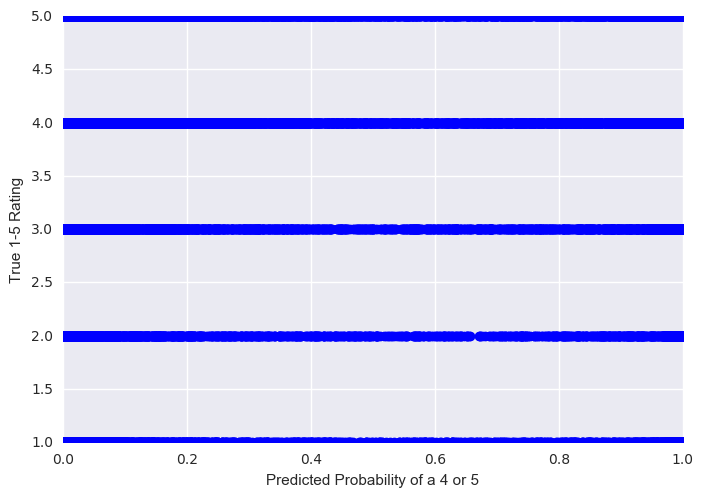

In [85]:
predicted_probability = clf.predict_proba(Xtestthis)[:, 0]
true_rating = rating[itest]

# fit with np.polyfit
m, b = np.polyfit(predicted_probability, true_rating , 1)
plt.plot(predicted_probability, true_rating, 'o', color = 'blue')
plt.plot(predicted_probability, m*predicted_probability + b, '+', color='red')
plt.xlabel('Predicted Probability of a 4 or 5')
plt.ylabel('True 1-5 Rating')
plt.show()

In [ ]:
#SVC grid search for the optimal parameter C

from sklearn.linear_model  import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from sklearn.feature_selection import chi2
from scipy import sparse
import itertools

Cs = [1e-2, 1e-1, 1, 10, 100]


#Find the best value for alpha and min_df, and the best classifier
best_C = None
maxscore=-np.inf

vectorizer = CountVectorizer(min_df= .0001, ngram_range = (1,2))
Xthis, ythis = make_xy(yelp_df, vectorizer)

#apply chi-squared for feature reduction
chi_squared, probability  = chi2(Xthis, ythis)
index_to_keep = []
for index, value in enumerate(probability):
    if value <= .05:
        index_to_keep.append(index)

new_Xthis = Xthis[:,index_to_keep]

#establish train and test sets
Xtrainthis = new_Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = new_Xthis[~mask]
ytestthis = ythis[~mask]
    
for c in Cs:
    
    clf  = LogisticRegression(C = c)
    clf.fit(Xtrainthis, ytrainthis)

    cvscore = cv_score(clf, Xtrainthis, ytrainthis, f1_score)

    if cvscore > maxscore:
        maxscore = cvscore
        best_C = c
    
print('C: {}'.format(best_C))

